In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from src.base.constants import *
from src.base.helpers import *
from src.base.vizwiz_eval_cap.eval import VizWizEvalCap
from src.demo_model.dataset import DemoDataset   ## This is a local import from dataset.pyA
from tqdm import tqdm
from transformers import AutoProcessor, BlipForConditionalGeneration, Blip2ForConditionalGeneration
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from transformers import AutoModelForCausalLM
from PIL import Image
import matplotlib.pyplot as plt
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /projectnb/ds598/students/qui
[nltk_data]     nnk/midterm/repo/misc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I did a lot of testing in this notebook, it was a really helpful way to interactively run small versions of the model

### Process and Load dataset

In [2]:
CACHE_DIR = os.environ.get("TRANSFORMERS_CACHE")

#create_directory(DEMO_SAVE_PATH)
#create_directory(DEMO_SAVE_PATH + "/examples")

## TODO
# You can use the AutoProcessor.from_pretrained() method to load the HuggingFace
# processor for the model you are using. This will allow you to use the processor
# to encode and decode text and images.
# https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoProcessor
try:
    # Some different processors that I was trying:
    # I landed on microsoft git large as a simple and effective choice
    
    #processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base", cache_dir=CACHE_DIR)
    #processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
    processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
except Exception as e:
    print("You need to pick a pre-trained model from HuggingFace.")
    print("Exception: ", e)

train_dataset = DemoDataset(
    processor=processor,
    annotation_file=TRAIN_ANNOTATION_FILE,
    image_folder=TRAIN_IMAGE_FOLDER,
    transforms=None,
)
val_dataset = DemoDataset(
    processor=processor,
    annotation_file=VAL_ANNOTATION_FILE,
    image_folder=VAL_IMAGE_FOLDER,
    transforms=None
)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created! imgs = 23431, anns = 100575
loading annotations into memory...
Done (t=0.07s)
creating index...
index created! imgs = 7750, anns = 33145


In [3]:
### Use the Subset while debugging ###
train_dataset = Subset(train_dataset, range(1000))
val_dataset = Subset(val_dataset, range(100))

### Since, subset is used above, the dataset object needs to be called with a .dataset, to access the original dataset. So while using the full dataset, the below is done. ###
#train_dataset = Subset(train_dataset, range(len(train_dataset)))
#val_dataset = Subset(val_dataset, range(len(val_dataset)))

print("SANITY CHECK!!")
print(f"LEN TRAIN IMAGE IDS: {len(train_dataset.dataset.image_ids)}")
print(f"LEN VAL IMAGE IDS: {len(val_dataset.dataset.image_ids)}")
print("SANITY CHECK DONE!!")


train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=3)

SANITY CHECK!!
LEN TRAIN IMAGE IDS: 22866
LEN VAL IMAGE IDS: 7542
SANITY CHECK DONE!!


### Define the model

In [4]:
## TODO
# You can use the AutoModelForCausalLM.from_pretrained() method to load the HuggingFace
# model you want to fine-tune. This will allow you to use the model to train and evaluate
# on the VizWiz dataset.
try:
    # Some different models that I was trying:
    # I landed on microsoft git large as a simple and effective choice
    
    #model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", cache_dir = CACHE_DIR)
    #model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
    model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-coco", cache_dir = CACHE_DIR)
except Exception as e:
    print("You need to pick a pre-trained model from HuggingFace.")
    print("Exception: ", e)

## TODO Select your model optimizer
try:
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)   # pick one from torch.optim
except Exception as e:
    print("You need to pick an optimizer from torch.optim.")
    print("Exception: ", e)

### Train and Evaluate

In [5]:
# Wrap the model with DataParallel only if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

method = "CIDEr"  # method used for comparsions

logger = Logger("/projectnb/ds598/students/quinnk/midterm/results2/logs.log")

In [6]:
def train(loger, train_dataloader, model, optimizer, device, processor):
    model.train()

    for idx, batch in progress_bar:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        # POP the attention mask
        attention_mask = batch.pop("attention_mask").to(device)

        #print(input_ids)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids, pixel_values=pixel_values, labels=input_ids, attention_mask = attention_mask
        )

        loss = outputs.loss
        if torch.cuda.device_count() > 1:
            loss = loss.mean()
        loss.backward()

        optimizer.step()

        # Update progress bar with loss info
        progress_bar.set_postfix({"loss": loss.item()})

    return loss.item()


def evaluate(
    logger, epoch, save_path, best_score, val_dataloader, model, processor, device
):
    model.eval()
    caption_val = []
    plot_captions_dict = {}
    for idx, batch in enumerate(val_dataloader):
        image_ids = batch.pop("image_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        with torch.no_grad():
            outputs = model.generate(pixel_values=pixel_values, max_length=50)

        # Decode the generated ids to text
        generated_captions = processor.batch_decode(outputs, skip_special_tokens=True)

        # Store the generated captions
        for img_id, caption in zip(image_ids, generated_captions):
            caption_val.append(
                {"image_id": img_id.item(), "caption": caption}
            )  # Used for VizWizEvalCap
            plot_captions_dict[img_id.item()] = caption  # Used for plotting

    # Save the generated captions to a json file
    with open(f"{save_path}/generated_captions.json", "w") as f:
        json.dump(caption_val, f, indent=4)

    vizwizRes = val_dataset.dataset.vizwiz.loadRes(
        f"{save_path}/generated_captions.json"
    )
    vizwizEval = VizWizEvalCap(val_dataset.dataset.vizwiz, vizwizRes)
    vizwizEval.evaluate()

    logger.info(f"Validation scores at epoch: {epoch}")
    for method in vizwizEval.eval:
        logger.info(f"  Method: {method}, Score: {vizwizEval.eval[method]:.4f}")

    return vizwizEval, vizwizRes, plot_captions_dict


In [7]:
def get_val_examples(vizwizEval, vizwizRes, plot_captions_dict, epoch, method="CIDEr"):
    # Get 5 best and 5 worst captions every epoch
    # Use first 3 idxs to plot throughout the training

    img_id_scores = vizwizEval.imgToEval

    best_img_ids = sorted(
        img_id_scores, key=lambda x: img_id_scores[x][method], reverse=True
    )[:5]
    worst_img_ids = sorted(img_id_scores, key=lambda x: img_id_scores[x][method])[:5]
    first_3_img_ids = list(img_id_scores.keys())[:3]

    best_img_paths = [
        os.path.join(
            val_dataset.dataset.image_folder,
            val_dataset.dataset.vizwiz.loadImgs(img_id)[0]["file_name"],
        )
        for img_id in best_img_ids
    ]
    worst_img_paths = [
        os.path.join(
            val_dataset.dataset.image_folder,
            val_dataset.dataset.vizwiz.loadImgs(img_id)[0]["file_name"],
        )
        for img_id in worst_img_ids
    ]
    first_3_img_paths = [
        os.path.join(
            val_dataset.dataset.image_folder,
            val_dataset.dataset.vizwiz.loadImgs(img_id)[0]["file_name"],
        )
        for img_id in first_3_img_ids
    ]

    best_img_and_captions = [
        (img_path, plot_captions_dict[img_id], vizwizEval.vizwiz.imgToAnns[img_id])
        for img_path, img_id in zip(best_img_paths, best_img_ids)
    ]  # get img path, generated caption and ground truth caption
    worst_img_and_captions = [
        (img_path, plot_captions_dict[img_id], vizwizEval.vizwiz.imgToAnns[img_id])
        for img_path, img_id in zip(worst_img_paths, worst_img_ids)
    ]
    first_3_img_and_captions = [
        (img_path, plot_captions_dict[img_id], vizwizEval.vizwiz.imgToAnns[img_id])
        for img_path, img_id in zip(first_3_img_paths, first_3_img_ids)
    ]

    # Save the images and captions
    save_image_captions(
        best_img_and_captions, f"/projectnb/ds598/students/quinnk/midterm/results2/examples/epoch_{epoch}/best/" #f"{DEMO_SAVE_PATH}/examples/epoch_{epoch}/best/"
    )
    save_image_captions(
        worst_img_and_captions, f"/projectnb/ds598/students/quinnk/midterm/results2/examples/epoch_{epoch}/worst/" #f"{DEMO_SAVE_PATH}/examples/epoch_{epoch}/worst/"
    )
    save_image_captions(
        first_3_img_and_captions, f"/projectnb/ds598/students/quinnk/midterm/results2/examples/epoch_{epoch}/first_3/" #f"{DEMO_SAVE_PATH}/examples/epoch_{epoch}/first_3/"
    )


In [ ]:
best_score = 0
for epoch in range(1):
    print(f"Epoch: {epoch+1}")
    # Wrap the dataloader with tqdm for a progress bar
    progress_bar = tqdm(
        enumerate(train_dataloader), total=len(train_dataloader), desc="Training"
    )

    # Train the model
    loss = train(logger, train_dataloader, model, optimizer, device, processor)
    logger.info(f"Loss at epoch {epoch}: {loss}")
    print(f"Loss at epoch {epoch}: {loss}")

    # Evaluate the model every 3 epochs
    if epoch % 3 == 0:
        vizwizEval, vizwizRes, plot_captions_dict = evaluate(
            logger,
            epoch,
            "/projectnb/ds598/students/quinnk/midterm/results2",
            best_score,
            val_dataloader,
            model,
            processor,
            device,
        )
        score = vizwizEval.eval[method]
        #if score > best_score:
        #    best_score = score
        #    model.save_pretrained(f"{DEMO_SAVE_PATH}/best_model")
        #    logger.info(f"New best score: {best_score}. Model saved")
        print(f"score: {score}")

        get_val_examples(vizwizEval, vizwizRes, plot_captions_dict, epoch, method)


Epoch: 1


Training: 100%|██████████| 7622/7622 [1:26:28<00:00,  1.47it/s, loss=0.0815]
INFO - Loss at epoch 0: 0.08149439841508865


Loss at epoch 0: 0.08149439841508865


### Display results

Cool!

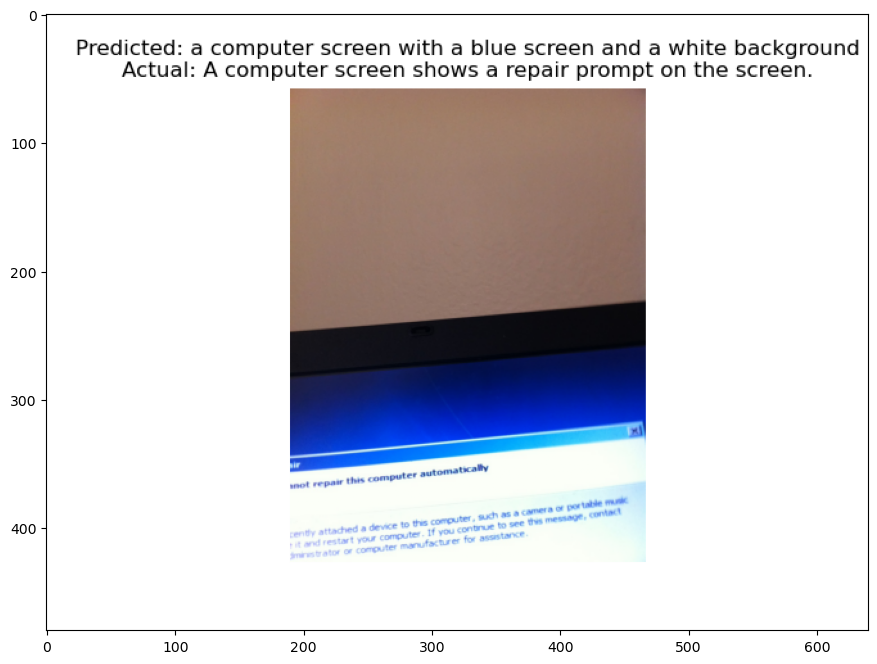

In [23]:
img = mpimg.imread('../results2/examples/epoch_3/first_3/caption_1.png')
fig,ax = plt.subplots(figsize = (14,8), dpi = 100)
ax.imshow(img)
plt.show()